In [3]:
# Автоматическая перезагрузка модулей при изменении
# Это позволяет обновлять код в helper.py, plots.py, nlp.py без перезапуска ядра
%load_ext autoreload
%autoreload 2


In [4]:
# Импорт необходимых библиотек для анализа данных
import pandas as pd  # для работы с табличными данными
import numpy as np   # для математических операций
import random        # для работы с генератором случайных чисел

# Импорт пользовательских модулей с функциями для анализа
from helper import *  # вспомогательные функции для обработки данных
from plots import *   # функции для визуализации
from nlp import *     # функции для обработки естественного языка


In [5]:
# Фиксация состояния генератора псевдослучайных чисел для воспроизводимости результатов
# Это критически важно для машинного обучения - результаты должны быть воспроизводимы
SEED = 42 # можно указать любое число
np.random.seed(SEED)  # для numpy операций
random.seed(SEED)     # для стандартного модуля random


## 1. Изучение структуры данных

**Цель:** Понять общую структуру датасета, количество записей, типы данных и качество информации.
Это первый и самый важный этап любого анализа данных - без понимания структуры невозможно корректно проводить дальнейшую обработку.


In [6]:
# Загружаем предобработанные данные из CSV файла
# Датасет содержит информацию о вакансиях с их описаниями и метками
df = pd.read_csv('imdb.csv')


In [7]:
# Выводим общую информацию о структуре датасета:
# - количество записей (1624)
# - количество столбцов (4)
# - типы данных в каждом столбце
# - количество пропущенных значений (в данном случае - отсутствуют)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


## 2. Проверка на корректность и качество данных

**Цель:** Выявить проблемы с данными, которые могут повлиять на качество анализа и моделирования.
Проверяем на дубликаты, пропущенные значения и аномальные записи.


### 2.1 Проверка на дубликаты

**Логика:** Дублированные записи могут искажать результаты анализа и обучения модели.
Если одна и та же вакансия встречается несколько раз, это может привести к переобучению.


In [8]:
# Подсчет числа полностью дублированных строк
# Результат: 0 означает, что дубликатов нет - это хорошо для качества данных
df.duplicated().sum()


np.int64(418)

### 2.2 Пропущенные значения

**Логика:** Пропущенные значения могут нарушить работу алгоритмов машинного обучения.
Нужно понять, есть ли пропуски и как они распределены по столбцам.


In [9]:
# Выводим число пропущенных значений по каждому столбцу
# Результат: все значения равны 0, что означает отсутствие пропусков - отличное качество данных
df.isnull().sum()


review       0
sentiment    0
dtype: int64

In [42]:
# Анализ коротких описаний (менее 100 символов)
# Короткие описания могут быть неинформативными или содержать служебную информацию
short_texts = df[df['review'].str.len() < 100]
print(f"всего коротких текстов {short_texts['review'].value_counts().sum()}")
short_texts['review'].value_counts()


всего коротких текстов 20


review
A rating of "1" does not begin to express how dull, depressing and relentlessly bad this movie is.    1
Long, boring, blasphemous. Never have I been so glad to see ending credits roll.                      1
no comment - stupid movie, acting average or worse... screenplay - no sense at all... SKIP IT!        1
Add this little gem to your list of holiday regulars. It is<br /><br />sweet, funny, and endearing    1
I hope this group of film-makers never re-unites.                                                     1
Ming The Merciless does a little Bardwork and a movie most foul!                                      1
What a script, what a story, what a mess!                                                             1
Just love the interplay between two great characters of stage & screen - Veidt & Barrymore            1
If you like Pauly Shore, you'll love Son in Law. If you hate Pauly Shore, then, well...I liked it!    1
Primary plot!Primary direction!Poor interpretation.      

In [11]:
# Удаляем строки с описанием "Unknown" - это неинформативные записи
# Такие записи не несут смысловой нагрузки для классификации
df = df[df['review'] != 'Unknown']


## 3. Детальное изучение признаков (и таргета)

**Цель:** Глубокий анализ каждого признака для понимания их информативности и распределения.
Это поможет выбрать правильные методы предобработки и понять, какие признаки наиболее важны для классификации.


In [13]:
# Создаем копию датасета для EDA, чтобы не изменять исходные данные
# Это позволяет безопасно экспериментировать с данными
df_EDA = df.copy()


### 3.1. Таргет (целевая переменная)

**Логика:** Анализ распределения целевой переменной критически важен для понимания задачи.
Нужно проверить баланс классов - если один класс сильно преобладает, это может потребовать специальных подходов.


In [28]:
df_EDA['is_positive'] = df_EDA['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

In [ ]:
# Анализируем распределение целевой переменной (is_positive)
# 1 если позитивный, 0 негативный
# Смотрим, насколько сбалансированы классы
df_EDA['is_positive'].value_counts()


is_positive
1    25000
0    25000
Name: count, dtype: int64

### 3.2. Анализ заголовков (Title)

**Логика:** Заголовки вакансий часто содержат ключевую информацию о специальности.
Анализируем длину, частотность слов и их важность для классификации.


In [15]:
# Создаем признак длины заголовка в символах
# Длина текста может быть важным признаком для классификации
df_EDA['review_char_length'] = df_EDA['review'].str.len()


In [ ]:
# Статистическое описание длины заголовков
# Видим среднюю, минимальную, максимальную длину и квартили
df_EDA['review_char_length'].describe()


count    50000.000000
mean      1309.431020
std        989.728014
min         32.000000
25%        699.000000
50%        970.000000
75%       1590.250000
max      13704.000000
Name: review_char_length, dtype: float64

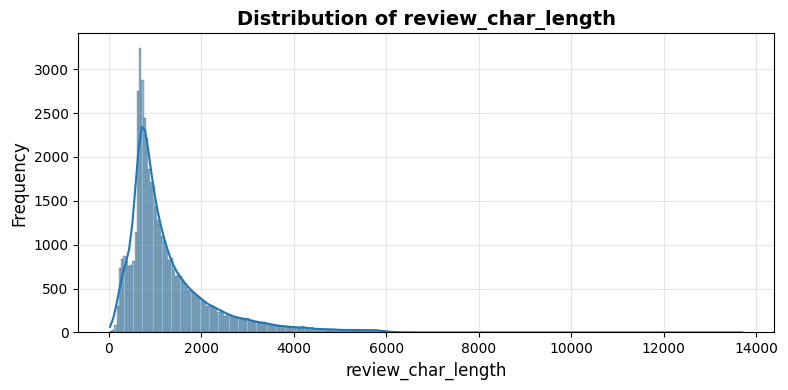

In [17]:
# Визуализируем распределение длины обзоров
# Гистограмма поможет понять, как распределена длина текстов
plot_hist_numeric(df_EDA, 'review_char_length')


In [18]:
# Токенизация заголовков с помощью tiktoken (токенизатор GPT)
# Tiktoken лучше работает с техническими терминами, чем стандартные токенизаторы
df_EDA['review_tokenized_tiktoken'] = df_EDA['review'].apply(tokenize_tiktoken)
df_EDA['review_tokenized_tiktoken_len'] = df_EDA['review_tokenized_tiktoken'].apply(len)


In [19]:
# Подсчет частотности токенов в заголовках
# Удаляем стоп-слова и пунктуацию, приводим к нижнему регистру для корректного подсчета
# Это поможет выявить наиболее частые слова в заголовках
_token_counts = token_counts(
    df_EDA, 
    'review_tokenized_tiktoken', 
    remove_stopwords=True, 
    remove_punctuation=True,
    lowercase_for_counting=True
)


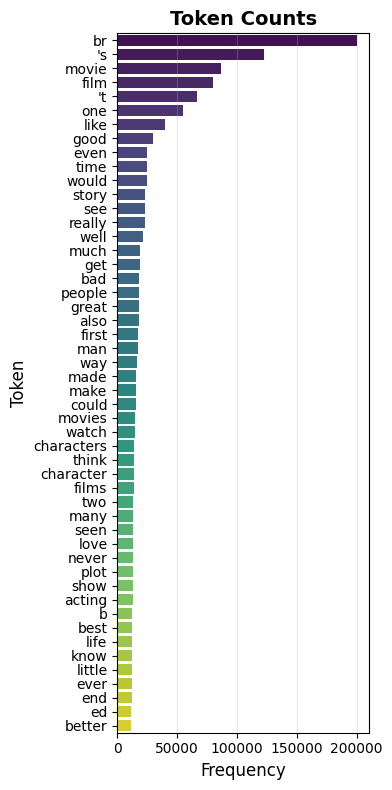

In [20]:
# Визуализация топ-50 самых частых токенов в заголовках
# Столбчатая диаграмма поможет быстро увидеть ключевые слова
barplot(
    _token_counts, 
    'Token Counts', 
    ylabel='Token', 
    top_n=50, 
    figsize=(4, 8)
)


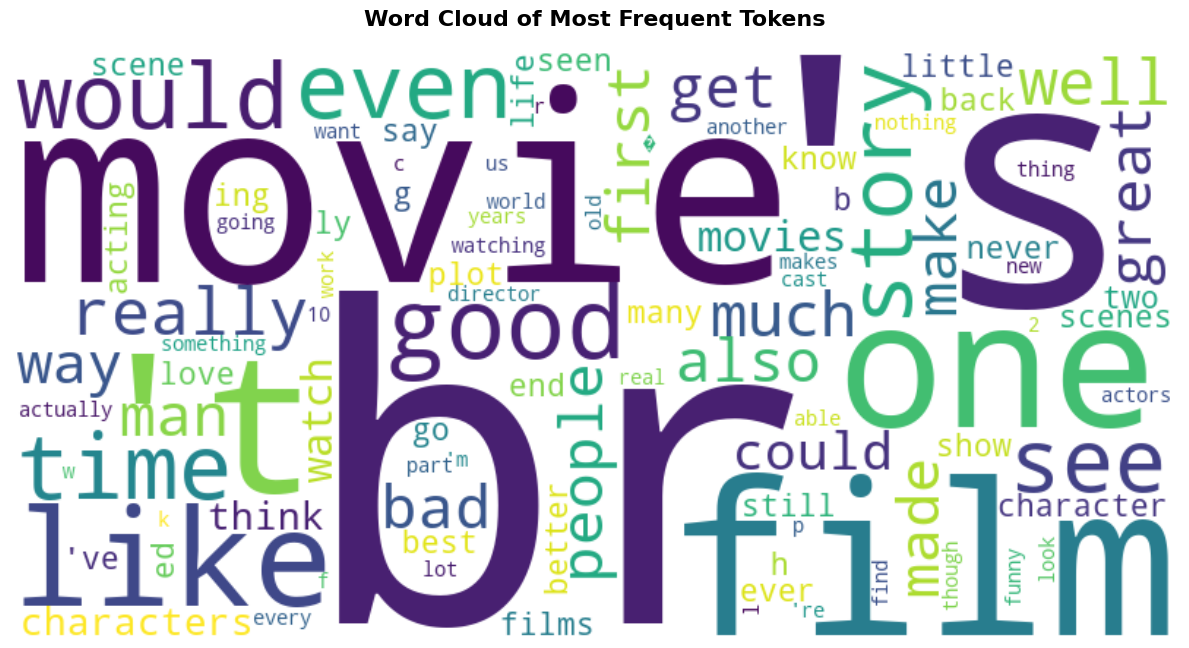

In [21]:
# Облако слов для визуализации частотности токенов
# Размер слова пропорционален его частотности - интуитивно понятная визуализация
plot_wordcloud(
    _token_counts, 
    'Word Cloud of Most Frequent Tokens', 
    max_words=100
)


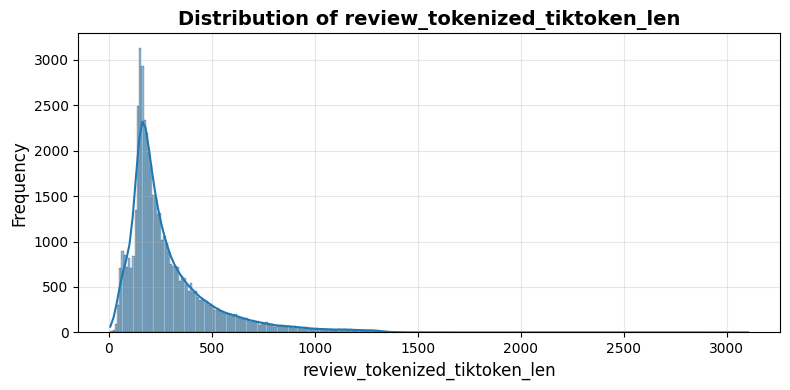

In [22]:
# Распределение количества токенов в заголовках
# Помогает понять, сколько слов в среднем содержит заголовок
plot_hist_numeric(df_EDA, 'review_tokenized_tiktoken_len')


In [23]:
df_EDA['review_tokenized_tiktoken_len'].describe()

count    50000.000000
mean       292.523660
std        219.376579
min          8.000000
25%        157.000000
50%        218.000000
75%        355.000000
max       3103.000000
Name: review_tokenized_tiktoken_len, dtype: float64

In [ ]:
#Квантили длины текстов по токенам
np.quantile(df_EDA['review_tokenized_tiktoken_len'], [0.8, 0.9, 0.95])

array([406., 575., 753.])

In [24]:
# Очистка токенов: удаляем стоп-слова и знаки пунктуации
# Это подготовка для анализа важности токенов для классификации
df_EDA['review_tokenized_tiktoken_clean'] = df_EDA['review_tokenized_tiktoken'].apply(lambda tokens: filter_tokens(
    tokens, 
    remove_stopwords=True, 
    remove_punct_tokens=True,
    lowercase_for_counting=True
))


In [25]:
# Анализ важности токенов для классификации с помощью ANOVA F-test
# n=3: анализируем 1-граммы, 2-граммы и 3-граммы
# min_count=50: учитываем только токены, встречающиеся минимум 50 раз
# Это поможет выявить наиболее информативные для классификации слова и фразы
_token_counts = count_based_analysis(
    texts_tokenized = df_EDA['review_tokenized_tiktoken_clean'], 
    labels = df_EDA['sentiment'], 
    n=1,
    metric='anova_f',
    min_count=10
)


In [26]:
# Выводим топ-5 наиболее важных для классификации токенов в заголовках
# Чем выше значение метрики, тем важнее токен для различения классов
_token_counts.head(5)


,token,metric,count_negative,freq_negative,count_positive,freq_positive,total_count
0,bad,3586.716854,14795,0.004167,3795,0.001041,18590
1,worst,2820.644709,4651,0.001310,430,0.000118,5081
2,great,2172.629447,5195,0.001463,12965,0.003556,18160
3,waste,1880.749636,2565,0.000722,172,0.000047,2737
4,awful,1608.273119,2873,0.000809,284,0.000078,3157


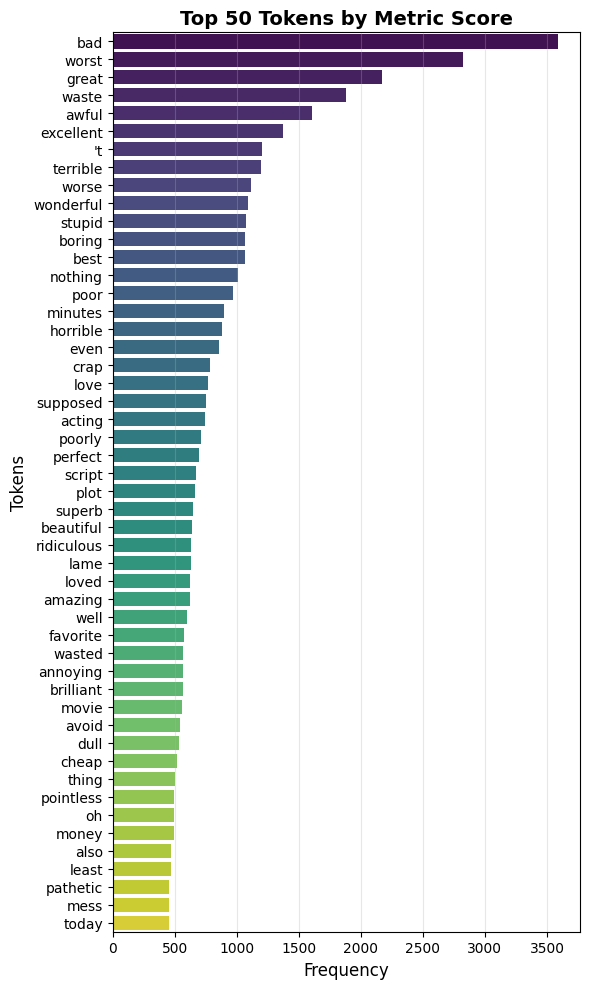

In [27]:
# Визуализация топ-50 токенов по важности для классификации
# Помогает понять, какие слова и фразы лучше всего различают DS и не-DS вакансии
barplot_data_metric = _token_counts.set_index('token')['metric'].head(50)
barplot(barplot_data_metric, 'Top 50 Tokens by Metric Score', 'Tokens', figsize=(6, 10))
